<h2 align="center"> Predicting Parkinson’s Disease </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./parkinsons3.data")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


#### Matrix column entries (attributes):
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
- NHR, HNR - Two measures of the ratio of noise to tonal components in the voice
- status - The health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE, D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

### Inspecting Data and Exploratory Data Analysis

In [3]:
df.shape

(200, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              200 non-null    object 
 1   MDVP:Fo(Hz)       200 non-null    float64
 2   MDVP:Fhi(Hz)      200 non-null    float64
 3   MDVP:Flo(Hz)      200 non-null    float64
 4   MDVP:Jitter(%)    200 non-null    float64
 5   MDVP:Jitter(Abs)  200 non-null    float64
 6   MDVP:RAP          200 non-null    float64
 7   MDVP:PPQ          200 non-null    float64
 8   Jitter:DDP        200 non-null    float64
 9   MDVP:Shimmer      200 non-null    float64
 10  MDVP:Shimmer(dB)  200 non-null    float64
 11  Shimmer:APQ3      200 non-null    float64
 12  Shimmer:APQ5      200 non-null    float64
 13  MDVP:APQ          200 non-null    float64
 14  Shimmer:DDA       200 non-null    float64
 15  NHR               200 non-null    float64
 16  HNR               200 non-null    float64
 1

- There are 22 float columns, 1 integer and 1 object column
- There are no null values 

In [5]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,155.226170,197.803775,117.165210,0.006160,0.000043,0.003278,0.003415,0.009835,0.029468,0.279980,...,0.046642,0.024617,21.975690,0.735000,0.497460,0.717965,-5.720146,0.224887,2.373946,0.203869
std,41.372137,90.499649,44.077681,0.004810,0.000035,0.002941,0.002736,0.008822,0.018774,0.193919,...,0.030341,0.040029,4.480667,0.442441,0.102961,0.054927,1.101145,0.083041,0.386561,0.090619
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.939750,135.570750,84.400500,0.003413,0.000020,0.001658,0.001840,0.004975,0.016428,0.145000,...,0.024343,0.005847,19.251750,0.000000,0.422229,0.674855,-6.499763,0.173319,2.094037,0.133663
50%,150.038000,178.215000,104.376000,0.004930,0.000030,0.002485,0.002650,0.007455,0.022965,0.219000,...,0.038335,0.011635,22.152000,1.000000,0.490441,0.722305,-5.756374,0.216609,2.352424,0.190881
75%,186.296000,224.804250,142.073250,0.007285,0.000053,0.003818,0.003953,0.011453,0.037777,0.350000,...,0.060708,0.026065,25.145000,1.000000,0.584415,0.760584,-5.103933,0.274630,2.635544,0.252080
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


- There are some outliers as we can see some attributes have huge difference in their 75 percentile value and maximum value. 

In [6]:
# for i in df.columns[1:]:
#     fig, ax = plt.subplots()
#     ax.boxplot(df[i])
#     plt.ylabel(i)

<AxesSubplot:ylabel='status'>

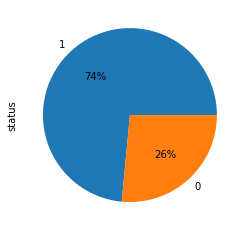

In [7]:
df['status'].value_counts().plot(kind='pie', autopct = "%1.0f%%")

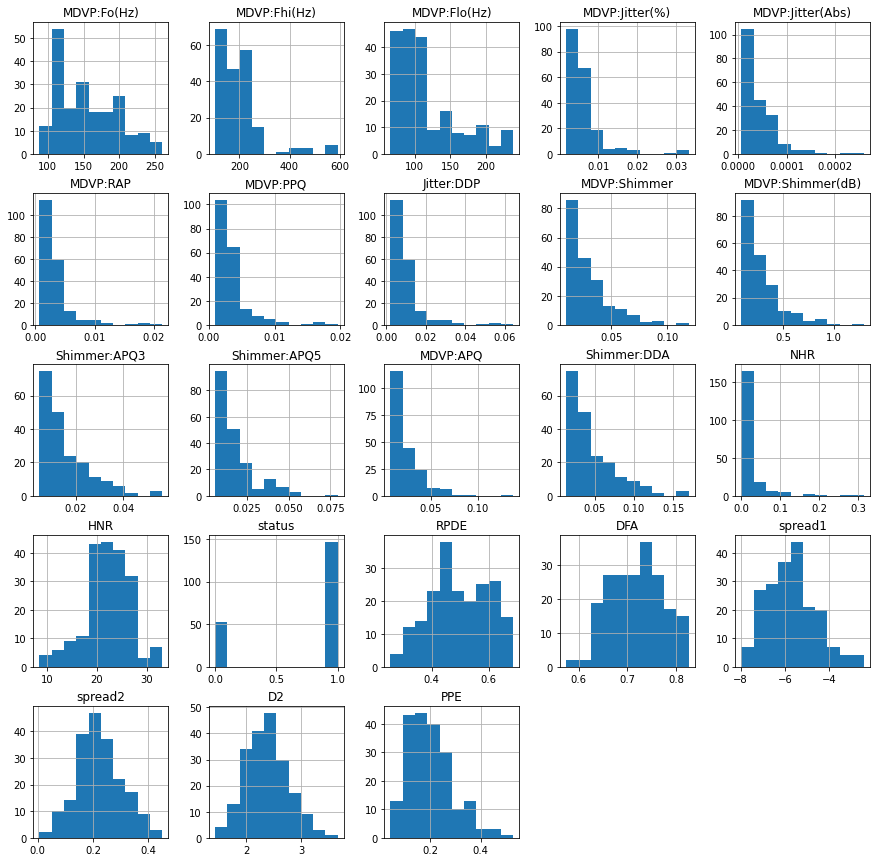

In [8]:
df.hist(figsize=(15,15));

<AxesSubplot:>

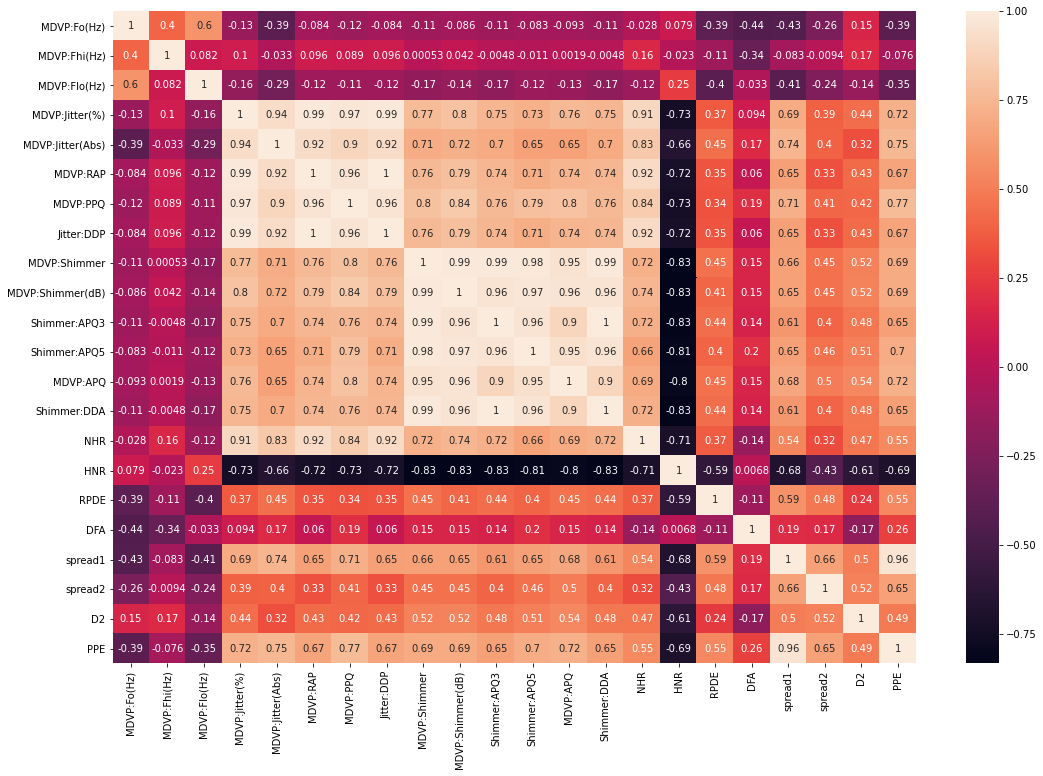

In [9]:
import seaborn as sns
fc=df.columns.tolist()
fc.remove('name')
fc.remove('status')
plt.figure(figsize=(18,12))
sns.heatmap(df[fc].corr(),annot=True)

- We can see some of the data is normally distributed and most of the attributes are right skewed

#### Data set stats

In [10]:
print("Original shape of data: ", df.shape)
x = df.drop(['status','name'], axis=1)
print("Featues shape:", x.shape)
y = df.status
print("Target shape: ", y.shape)

Original shape of data:  (200, 24)
Featues shape: (200, 22)
Target shape:  (200,)


#### Min-Max Scaler 

In [11]:
scaler = MinMaxScaler((-1, 1))
# fits the data normally 
X = scaler.fit_transform(x) 

### Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2) 

In [13]:
df_final = pd.DataFrame(columns=['model','data_set','accuracy'])
# df_final.loc[len(df_final)]= ['Logistic','train',train_acc]

<h2 align='center'> Logistic Regression </h2>

In [14]:
solver = ['newton-cg','lbfgs','liblinear']
C =     [0.1, 1, 10, 100, 1000]
grid = dict(solver=solver,C=C)
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=1)
lr = LogisticRegression()
grid_search = GridSearchCV(estimator=lr,param_grid=grid,n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_result=grid_search.fit(x_train,y_train)

In [15]:
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
df_final.loc[len(df_final)]= ['Logistic','train',grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_lr = pd.DataFrame(columns=['C','solver','accuracy'])
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    df_lr.loc[len(df_lr)]= [param.get('C'),param.get('solver'),mean]
    

Best: 0.859375 using {'C': 1000, 'solver': 'newton-cg'}

0.843750 (0.046351) with: {'C': 0.1, 'solver': 'newton-cg'}
0.843750 (0.046351) with: {'C': 0.1, 'solver': 'lbfgs'}
0.853125 (0.053309) with: {'C': 0.1, 'solver': 'liblinear'}
0.834375 (0.063354) with: {'C': 1, 'solver': 'newton-cg'}
0.834375 (0.063354) with: {'C': 1, 'solver': 'lbfgs'}
0.843750 (0.060917) with: {'C': 1, 'solver': 'liblinear'}
0.837500 (0.066732) with: {'C': 10, 'solver': 'newton-cg'}
0.837500 (0.066732) with: {'C': 10, 'solver': 'lbfgs'}
0.834375 (0.069245) with: {'C': 10, 'solver': 'liblinear'}
0.856250 (0.068750) with: {'C': 100, 'solver': 'newton-cg'}
0.856250 (0.068750) with: {'C': 100, 'solver': 'lbfgs'}
0.856250 (0.068750) with: {'C': 100, 'solver': 'liblinear'}
0.859375 (0.062108) with: {'C': 1000, 'solver': 'newton-cg'}
0.853125 (0.072011) with: {'C': 1000, 'solver': 'lbfgs'}
0.859375 (0.062108) with: {'C': 1000, 'solver': 'liblinear'}


In [16]:
bm = grid_result.best_estimator_
x_pred = bm.predict(x_test)
test_acc = accuracy_score(y_test, x_pred)
print("Test Accuracy: ",test_acc)
df_final.loc[len(df_final)]= ['Logistic','test',test_acc]

Test Accuracy:  0.925


(0.7, 0.9)

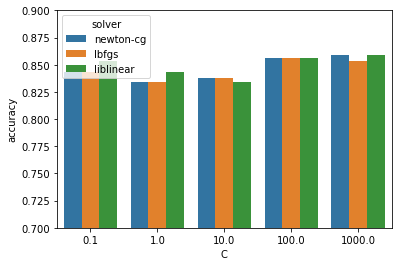

In [17]:
g = sns.barplot(x='C', y ='accuracy', data=df_lr,hue='solver')
g.set_ylim(.7,.9)

In [18]:
print("\nClassification Report:")
print(classification_report(y_test, x_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.93      0.96      0.94        26

    accuracy                           0.93        40
   macro avg       0.92      0.91      0.92        40
weighted avg       0.92      0.93      0.92        40



<h2 align='center'> Ridge Classifier </h2>

In [19]:
alpha = [0.1, .2, .3, .4, .5,.6,.7,.8,.9,1]
grid = dict(alpha=alpha)
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=1)
rc = RidgeClassifier()
grid_search = GridSearchCV(estimator=rc,param_grid=grid,n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_result=grid_search.fit(x_train,y_train)

In [20]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
df_final.loc[len(df_final)]= ['Ridge','train',grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_rc = pd.DataFrame(columns=['alpha','accuracy'])
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    df_rc.loc[len(df_rc)]= [param.get('alpha'),mean]

Best: 0.868750 using {'alpha': 0.2}
0.865625 (0.056854) with: {'alpha': 0.1}
0.868750 (0.051916) with: {'alpha': 0.2}
0.868750 (0.043750) with: {'alpha': 0.3}
0.865625 (0.040865) with: {'alpha': 0.4}
0.865625 (0.040865) with: {'alpha': 0.5}
0.862500 (0.042390) with: {'alpha': 0.6}
0.862500 (0.042390) with: {'alpha': 0.7}
0.862500 (0.042390) with: {'alpha': 0.8}
0.859375 (0.047905) with: {'alpha': 0.9}
0.856250 (0.044634) with: {'alpha': 1}


In [21]:
bm = grid_result.best_estimator_
x_pred = bm.predict(x_test)
test_acc = accuracy_score(y_test, x_pred)
print("Test Accuracy: ",test_acc)
df_final.loc[len(df_final)]= ['Ridge','test',test_acc]

Test Accuracy:  0.9


(0.8, 0.9)

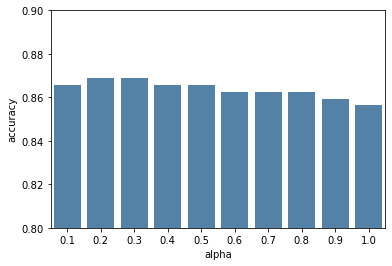

In [22]:
g = sns.barplot(x='alpha', y ='accuracy', data=df_rc,color='steelblue')
g.set_ylim(.8,.9)

In [23]:
print("\nClassification Report:")
print(classification_report(y_test, x_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        14
           1       0.87      1.00      0.93        26

    accuracy                           0.90        40
   macro avg       0.93      0.86      0.88        40
weighted avg       0.91      0.90      0.90        40



<h2 align='center'> Decision Tree </h2>

In [24]:
dt = DecisionTreeClassifier()
grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=1)
grid_search = GridSearchCV(estimator=dt,param_grid=grid,n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_result=grid_search.fit(x_train,y_train)

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
df_final.loc[len(df_final)]= ['Decision_tree','train',grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_dt = pd.DataFrame(columns=['max_depth','min_samples_leaf','accuracy'])
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    df_dt.loc[len(df_dt)]= [param.get('max_depth'),param.get('min_samples_leaf'),mean]

Best: 0.850000 using {'max_depth': 10, 'min_samples_leaf': 5}
0.818750 (0.081250) with: {'max_depth': 2, 'min_samples_leaf': 5}
0.834375 (0.074674) with: {'max_depth': 2, 'min_samples_leaf': 10}
0.821875 (0.066365) with: {'max_depth': 2, 'min_samples_leaf': 20}
0.756250 (0.078810) with: {'max_depth': 2, 'min_samples_leaf': 50}
0.756250 (0.018750) with: {'max_depth': 2, 'min_samples_leaf': 100}
0.846875 (0.084952) with: {'max_depth': 3, 'min_samples_leaf': 5}
0.815625 (0.080222) with: {'max_depth': 3, 'min_samples_leaf': 10}
0.806250 (0.070986) with: {'max_depth': 3, 'min_samples_leaf': 20}
0.756250 (0.078810) with: {'max_depth': 3, 'min_samples_leaf': 50}
0.756250 (0.018750) with: {'max_depth': 3, 'min_samples_leaf': 100}
0.846875 (0.075195) with: {'max_depth': 5, 'min_samples_leaf': 5}
0.843750 (0.085009) with: {'max_depth': 5, 'min_samples_leaf': 10}
0.806250 (0.070986) with: {'max_depth': 5, 'min_samples_leaf': 20}
0.756250 (0.078810) with: {'max_depth': 5, 'min_samples_leaf': 50}
0

In [26]:
bm = grid_result.best_estimator_
x_pred = bm.predict(x_test)
test_acc = accuracy_score(y_test, x_pred)
print("Test Accuracy: ",test_acc)
df_final.loc[len(df_final)]= ['Decision_tree','test',test_acc]

Test Accuracy:  0.875


(0.7, 0.9)

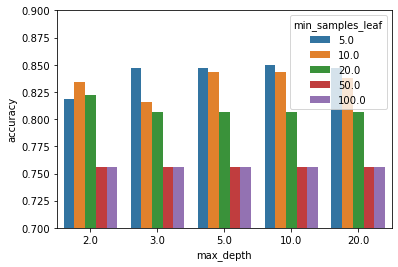

In [27]:
g = sns.barplot(x='max_depth', y ='accuracy', data=df_dt,hue='min_samples_leaf')
g.set_ylim(.7,.9)

In [28]:
print("\nClassification Report:")
print(classification_report(y_test, x_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.89      0.92      0.91        26

    accuracy                           0.88        40
   macro avg       0.87      0.85      0.86        40
weighted avg       0.87      0.88      0.87        40



<h2 align='center'> SVM </h2>

In [29]:
# kernel = ['linear','rbf','poly','sigmoid']
gamma = [0.1, 1, 10, 100]
C =     [0.1, 1, 10, 100, 1000]
grid = dict(gamma=gamma,C=C)
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=1)
svc = SVC()
grid_search = GridSearchCV(estimator=svc,param_grid=grid,n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_result=grid_search.fit(x_train,y_train)

In [30]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
df_final.loc[len(df_final)]= ['SVM','train',grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_svc = pd.DataFrame(columns=['C','gamma','accuracy'])
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    df_svc.loc[len(df_svc)]= [param.get('C'),param.get('gamma'),mean]

Best: 0.946875 using {'C': 10, 'gamma': 1}
0.756250 (0.018750) with: {'C': 0.1, 'gamma': 0.1}
0.756250 (0.018750) with: {'C': 0.1, 'gamma': 1}
0.756250 (0.018750) with: {'C': 0.1, 'gamma': 10}
0.756250 (0.018750) with: {'C': 0.1, 'gamma': 100}
0.859375 (0.038906) with: {'C': 1, 'gamma': 0.1}
0.928125 (0.056854) with: {'C': 1, 'gamma': 1}
0.821875 (0.053309) with: {'C': 1, 'gamma': 10}
0.793750 (0.034799) with: {'C': 1, 'gamma': 100}
0.881250 (0.070986) with: {'C': 10, 'gamma': 0.1}
0.946875 (0.049509) with: {'C': 10, 'gamma': 1}
0.825000 (0.050775) with: {'C': 10, 'gamma': 10}
0.793750 (0.034799) with: {'C': 10, 'gamma': 100}
0.909375 (0.063967) with: {'C': 100, 'gamma': 0.1}
0.946875 (0.049509) with: {'C': 100, 'gamma': 1}
0.825000 (0.050775) with: {'C': 100, 'gamma': 10}
0.793750 (0.034799) with: {'C': 100, 'gamma': 100}
0.918750 (0.052663) with: {'C': 1000, 'gamma': 0.1}
0.946875 (0.049509) with: {'C': 1000, 'gamma': 1}
0.825000 (0.050775) with: {'C': 1000, 'gamma': 10}
0.793750 (0.

(0.6, 0.96)

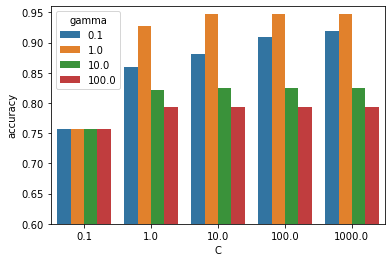

In [31]:
g = sns.barplot(x='C', y ='accuracy', data=df_svc,hue='gamma')
g.set_ylim(.6,.96)

In [32]:
bm = grid_result.best_estimator_
x_pred = bm.predict(x_test)
test_acc = accuracy_score(y_test, x_pred)
print("Test Accuracy: ",test_acc)
df_final.loc[len(df_final)]= ['SVM','test',test_acc]

Test Accuracy:  0.95


In [33]:
print("\nClassification Report:")
print(classification_report(y_test, x_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.96      0.96      0.96        26

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



<h2 align='center'> Random Forest </h2>

In [34]:
rf = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=2,random_state=1)

grid_search = GridSearchCV(estimator=rf,param_grid=grid,n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_result=grid_search.fit(x_train,y_train)

In [35]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
df_final.loc[len(df_final)]= ['Random_forest','train',grid_result.best_score_]
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_rf = pd.DataFrame(columns=['n_estimators','max_features','accuracy'])
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    df_rf.loc[len(df_rf)]= [param.get('n_estimators'),param.get('max_features'),mean]

Best: 0.928125 using {'max_features': 'log2', 'n_estimators': 100}
0.896875 (0.056854) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.921875 (0.047905) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.925000 (0.050775) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.890625 (0.055463) with: {'max_features': 'log2', 'n_estimators': 10}
0.928125 (0.049509) with: {'max_features': 'log2', 'n_estimators': 100}
0.925000 (0.050775) with: {'max_features': 'log2', 'n_estimators': 1000}


(0.8, 0.96)

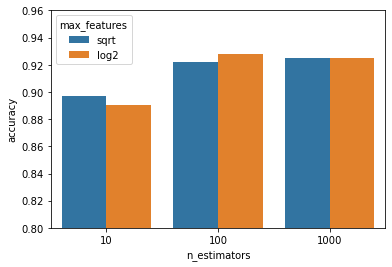

In [36]:
g = sns.barplot(x='n_estimators', y ='accuracy', data=df_rf,hue='max_features')
g.set_ylim(.8,.96)

In [37]:
bm = grid_result.best_estimator_
x_pred = bm.predict(x_test)
test_acc = accuracy_score(y_test, x_pred)
print("Test Accuracy: ",test_acc)
df_final.loc[len(df_final)]= ['Random_forest','test',test_acc]

Test Accuracy:  0.925


In [38]:
print("\nClassification Report:")
print(classification_report(y_test, x_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.90      1.00      0.95        26

    accuracy                           0.93        40
   macro avg       0.95      0.89      0.91        40
weighted avg       0.93      0.93      0.92        40



In [39]:
# acc = cross_val_score(svc,x_train, y_train.ravel(),cv=5)

<h2 align='center'>  Feed Froward Neural Network Binary Classification </h2>

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [41]:
class pddataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(np.array(x),dtype=torch.float32)
    self.y = torch.tensor(np.array(y),dtype=torch.long)
    self.length = self.x.shape[0]
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

In [42]:
df = y_train
target = df
classes = [0,1]
features = x_train

train_ds = pddataset(features,target)
train_loader = DataLoader(dataset=train_ds,shuffle=True,batch_size=20)

In [43]:
df = y_test
target = df
features = x_test

test_ds = pddataset(features,target)
test_loader = DataLoader(dataset=test_ds,shuffle=True,batch_size=20)

In [44]:
df = y_test
target = df
features = x_test

val_ds = pddataset(features,target)
val_loader = DataLoader(dataset=test_ds,shuffle=True,batch_size=20)

### Implement a Feed Forward Neural Network

In [45]:
class FFNN(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Create remaining hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(0, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Create output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
#         out = xb.view(xb.size(0), -1)
        out = xb.view(-1, 22).requires_grad_()

        out = self.input_layer(out)
#         out = torch.sigmoid(out)
        out = F.relu(out)        
        for layer in self.hidden_layers:
            out = layer(out)
            out = F.relu(out)
        
        # Get predictions
        out = self.output_layer(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss.detach()
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return epoch_loss.item()
    
    def epoch_end(self, epoch, train_loss, valid_loss):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, train_loss, valid_loss))

In [46]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    train_losslist = []
    valid_losslist = []
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(batch[0]) #.size(0)
            
            
        valid_loss = evaluate(model, val_loader)
        if epoch == 0 or epoch%20 == 0: 
            model.epoch_end(epoch, train_loss/len(train_loader.dataset), valid_loss)
            train_losslist.append(train_loss/len(train_loader.dataset))
            valid_losslist.append(valid_loss)
    return train_losslist, valid_losslist

In [47]:
def plot_loss(train_loss, valid_loss):
    losses = [x for x in train_loss]
    plt.plot(losses, '-x',label ='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    val_loss = [x for x in valid_loss]
    plt.plot(val_loss, '-x',label ='val loss')
    plt.legend()
    plt.title('Train Loss and valid loss');

#### Train the NN with one hidden layer having 32 neurons

In [48]:
input_size = 22
output_size = 2
hidden_size = 32
num_hidden_layers = 1
epochs = 281
model = FFNN(input_size, num_hidden_layers, hidden_size, output_size)

In [49]:
df_nn = pd.DataFrame(columns=['hidden_layers','neurons','data_set','accuracy'])
# df_nn.loc[len(df_nn)]= [param.get('hidden_layers'),param.get('neurons'),train_acc,test_acc]

In [50]:
train_losslist = []
valid_losslist = []
train_losslist, valid_losslist = fit(epochs, .05, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6912, val_loss: 0.6662
Epoch [20], train_loss: 0.4271, val_loss: 0.4807
Epoch [40], train_loss: 0.3477, val_loss: 0.3272
Epoch [60], train_loss: 0.3119, val_loss: 0.3196
Epoch [80], train_loss: 0.2953, val_loss: 0.2576
Epoch [100], train_loss: 0.2775, val_loss: 0.2482
Epoch [120], train_loss: 0.2610, val_loss: 0.2399
Epoch [140], train_loss: 0.2401, val_loss: 0.2539
Epoch [160], train_loss: 0.2015, val_loss: 0.2278
Epoch [180], train_loss: 0.1975, val_loss: 0.2093
Epoch [200], train_loss: 0.1533, val_loss: 0.2042
Epoch [220], train_loss: 0.1308, val_loss: 0.2101
Epoch [240], train_loss: 0.1516, val_loss: 0.1740
Epoch [260], train_loss: 0.1033, val_loss: 0.1621
Epoch [280], train_loss: 0.0777, val_loss: 0.1623


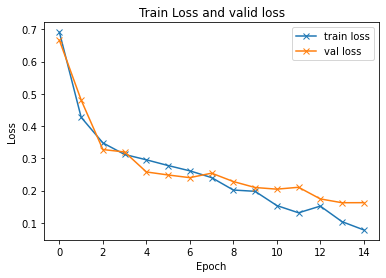

In [51]:
plot_loss(train_losslist, valid_losslist)

#### mean classification accuracy

In [52]:
def print_accuracy(test_loader):
    # prepare to count predictions for each class
    correct_pred = {cls: 0 for cls in classes}
    total_pred = {cls: 0 for cls in classes}

    n_correct = 0
    n_samples = 0

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                    n_correct += 1
                n_samples += 1
                total_pred[classes[label]] += 1

    acc = n_correct/n_samples
    print(f'\nMean Accuracy : {100*acc:.2f} %')
    return acc

In [53]:
train_acc = print_accuracy(train_loader)


Mean Accuracy : 98.12 %


In [54]:
test_acc = print_accuracy(test_loader)


Mean Accuracy : 90.00 %


In [55]:
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'train',train_acc]
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'test',test_acc]

#### Train the NN with two hidden layers having 32 neurons each

In [56]:
input_size = 22
output_size = 2
hidden_size = 32
num_hidden_layers = 2
epochs = 281
model = FFNN(input_size, num_hidden_layers, hidden_size, output_size)

In [57]:
train_losslist = []
valid_losslist = []
train_losslist, valid_losslist = fit(epochs, .05, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6447, val_loss: 0.6533
Epoch [20], train_loss: 0.4444, val_loss: 0.5239
Epoch [40], train_loss: 0.3343, val_loss: 0.3527
Epoch [60], train_loss: 0.3072, val_loss: 0.3172
Epoch [80], train_loss: 0.2864, val_loss: 0.2444
Epoch [100], train_loss: 0.2508, val_loss: 0.2723
Epoch [120], train_loss: 0.2285, val_loss: 0.2340
Epoch [140], train_loss: 0.2405, val_loss: 0.2032
Epoch [160], train_loss: 0.3374, val_loss: 0.2805
Epoch [180], train_loss: 0.2424, val_loss: 0.5557
Epoch [200], train_loss: 0.0969, val_loss: 0.1573
Epoch [220], train_loss: 0.1698, val_loss: 0.1121
Epoch [240], train_loss: 0.0876, val_loss: 0.5924
Epoch [260], train_loss: 0.0298, val_loss: 0.0945
Epoch [280], train_loss: 0.0240, val_loss: 0.1006


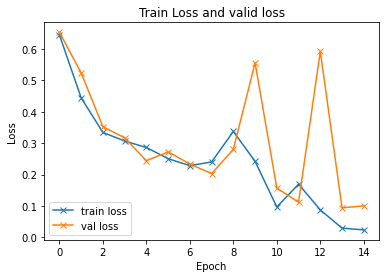

In [58]:
plot_loss(train_losslist, valid_losslist)

In [59]:
train_acc = print_accuracy(train_loader)


Mean Accuracy : 99.38 %


In [60]:
test_acc = print_accuracy(test_loader)


Mean Accuracy : 95.00 %


In [61]:
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'train',train_acc]
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'test',test_acc]

#### using 64 neurons for the hidden layer

In [62]:
input_size = 22
output_size = 2
hidden_size = 64
num_hidden_layers = 1
epochs = 281
model = FFNN(input_size, num_hidden_layers, hidden_size, output_size)

In [63]:
train_losslist = []
valid_losslist = []
train_losslist, valid_losslist = fit(epochs, .05, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6556, val_loss: 0.6442
Epoch [20], train_loss: 0.3782, val_loss: 0.3911
Epoch [40], train_loss: 0.3246, val_loss: 0.3709
Epoch [60], train_loss: 0.3087, val_loss: 0.2807
Epoch [80], train_loss: 0.3383, val_loss: 0.2613
Epoch [100], train_loss: 0.2807, val_loss: 0.2577
Epoch [120], train_loss: 0.2658, val_loss: 0.2495
Epoch [140], train_loss: 0.2287, val_loss: 0.2246
Epoch [160], train_loss: 0.1968, val_loss: 0.2592
Epoch [180], train_loss: 0.1507, val_loss: 0.1985
Epoch [200], train_loss: 0.1313, val_loss: 0.1665
Epoch [220], train_loss: 0.0992, val_loss: 0.2515
Epoch [240], train_loss: 0.0847, val_loss: 0.1345
Epoch [260], train_loss: 0.0707, val_loss: 0.1178
Epoch [280], train_loss: 0.0538, val_loss: 0.1778


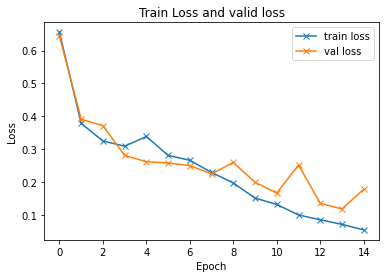

In [64]:
plot_loss(train_losslist, valid_losslist)

In [65]:
train_acc = print_accuracy(train_loader)


Mean Accuracy : 99.38 %


In [66]:
test_acc = print_accuracy(test_loader)


Mean Accuracy : 92.50 %


In [67]:
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'train',train_acc]
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'test',test_acc]

#### using 64 neurons with two hidden layers

In [68]:
input_size = 22
output_size = 2
hidden_size = 64
num_hidden_layers = 2
epochs = 281
model = FFNN(input_size, num_hidden_layers, hidden_size, output_size)

In [69]:
train_losslist = []
valid_losslist = []
train_losslist, valid_losslist = fit(epochs, .05, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6402, val_loss: 0.6463
Epoch [20], train_loss: 0.4211, val_loss: 0.4702
Epoch [40], train_loss: 0.3306, val_loss: 0.3146
Epoch [60], train_loss: 0.3257, val_loss: 0.2745
Epoch [80], train_loss: 0.2578, val_loss: 0.2531
Epoch [100], train_loss: 0.2602, val_loss: 0.2721
Epoch [120], train_loss: 0.1780, val_loss: 0.1747
Epoch [140], train_loss: 0.1318, val_loss: 0.1723
Epoch [160], train_loss: 0.1301, val_loss: 0.1734
Epoch [180], train_loss: 0.0795, val_loss: 0.2457
Epoch [200], train_loss: 0.0583, val_loss: 0.2039
Epoch [220], train_loss: 0.0420, val_loss: 0.1431
Epoch [240], train_loss: 0.0343, val_loss: 0.2829
Epoch [260], train_loss: 0.0215, val_loss: 0.1903
Epoch [280], train_loss: 0.0317, val_loss: 0.3078


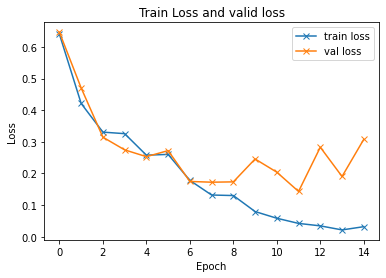

In [70]:
plot_loss(train_losslist, valid_losslist)

In [71]:
train_acc = print_accuracy(train_loader)


Mean Accuracy : 99.38 %


In [72]:
test_acc = print_accuracy(test_loader)


Mean Accuracy : 90.00 %


In [73]:
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'train',train_acc]
df_nn.loc[len(df_nn)]= [num_hidden_layers,hidden_size,'test',test_acc]

In [74]:
df_final.loc[len(df_final)]= ['FFNN','train',train_acc]
df_final.loc[len(df_final)]= ['FFNN','test',test_acc]

In [75]:
df_nn

,hidden_layers,neurons,data_set,accuracy
0,1,32,train,0.98125
1,1,32,test,0.90000
2,2,32,train,0.99375
3,2,32,test,0.95000
4,1,64,train,0.99375
5,1,64,test,0.92500
6,2,64,train,0.99375
7,2,64,test,0.90000


(0.8, 1.0)

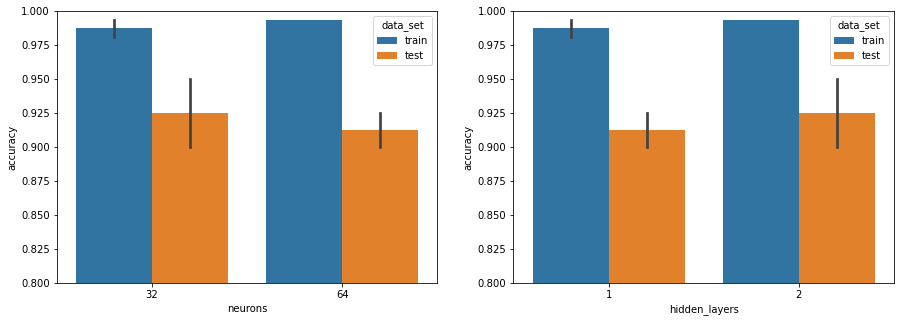

In [76]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
g = sns.barplot(ax=ax[0],x='neurons', y ='accuracy', data=df_nn,hue='data_set')
g.set_ylim(.8,1)
g = sns.barplot(ax=ax[1],x='hidden_layers', y ='accuracy', data=df_nn,hue='data_set')
g.set_ylim(.8,1)

In [77]:
df_final

,model,data_set,accuracy
0,Logistic,train,0.859375
1,Logistic,test,0.925000
2,Ridge,train,0.868750
3,Ridge,test,0.900000
4,Decision_tree,train,0.850000
5,Decision_tree,test,0.875000
6,SVM,train,0.946875
7,SVM,test,0.950000
8,Random_forest,train,0.928125
9,Random_forest,test,0.925000


(0.6, 1.0)

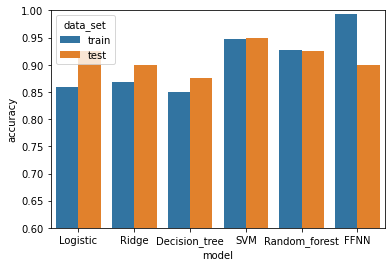

In [78]:
g = sns.barplot(x='model', y ='accuracy', data=df_final,hue='data_set')
g.set_ylim(.6,1)